<a href="https://colab.research.google.com/github/BrendaLoznik/waterpumps/blob/main/2.%20Data%20cleaning%20%26%20Feature%20engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Housekeeping

### 1.1 Load libraries

In [154]:
#basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from dirty_cat import SimilarityEncoder
from sklearn.preprocessing import normalize

In [155]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)

### 1.2 Load data

In [156]:
#import data
train_labels = pd.read_csv('../data/train/labels.csv')
train_values = pd.read_csv('../data/train/features.csv', parse_dates = ['date_recorded' ],  na_values = [0, '0'])
test_values = pd.read_csv('../data/test/test.csv', parse_dates = ['date_recorded' ] , na_values = [0, '0'])

#merge train values and train labels to single dataset
train= pd.merge(train_labels , train_values, on='id')


In [157]:
#concatenate train and test for data visualization
raw = pd.concat([train, test_values])
raw.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,NaN,Lake Nyasa,Mnyusi B,Iringa,11,5.0,Ludewa,Mundindi,109.0,True,GeoData Consultants Ltd,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,NaN,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,NaN,Lake Victoria,Nyamara,Mara,20,2.0,Serengeti,Natta,280.0,NaN,GeoData Consultants Ltd,Other,NaN,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,NaN,Pangani,Majengo,Manyara,21,4.0,Simanjiro,Ngorika,250.0,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,NaN,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,NaN,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63.0,Nanyumbu,Nanyumbu,58.0,True,GeoData Consultants Ltd,VWC,NaN,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,NaN,2011-07-13,Action In A,NaN,Artisan,31.130847,-1.825359,Shuleni,NaN,Lake Victoria,Kyanyamisa,Kagera,18,1.0,Karagwe,Nyakasimbi,NaN,True,GeoData Consultants Ltd,NaN,NaN,True,NaN,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


### 1.3 Custom functions

In [158]:


def plot_similarity(labels, features):
  
    normalized_features = normalize(features)
    
    # Create correction matrix
    corr = np.inner(normalized_features, normalized_features)
    
    # Plot
    mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=(30,30)) 
    ax = sns.heatmap(corr, mask=mask, cmap= "RdYlGn", vmin=0, linewidths=1, annot=True, fmt=".2f", xticklabels=labels, annot_kws={"size": 9})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
    plt.show()


def encode_and_plot(labels):
  
    enc = SimilarityEncoder(similarity="ngram") # Encode
    X_enc = enc.fit_transform(labels.reshape(-1, 1))
    
    plot_similarity(labels, X_enc) # Plot

In [159]:
def distribution_checker (data, xlabel):
  grouped = data.groupby([xlabel, 'status_group'])['id'].count().reset_index()
  pivot = grouped.pivot_table(index = xlabel, columns = 'status_group', fill_value = 0)
  mi=pivot.columns
  mi.tolist()
  ind = pd.Index([ str(e[1])  for e in mi.tolist()])
  pivot.columns = ind
  pivot['nr_pumps'] = pivot['functional'] +pivot['functional needs repair'] +pivot['non functional']
  pivot['all_pumps'] = pivot['nr_pumps'].sum()
  pivot['perc_total_pumps'] =((pivot['nr_pumps']/pivot['all_pumps'])*100).round(1)
  pivot['perc_functional'] = ((pivot['functional']/pivot['nr_pumps'])*100).round(1)
  pivot['perc_non_functional'] = ((pivot['non functional']/pivot['nr_pumps'])*100).round(1)
  pivot['perc_functional_needs_repair'] = ((pivot['functional needs repair']/pivot['nr_pumps'])*100).round(1)
  pivot = pivot.drop(['functional', 'functional needs repair', 'non functional', 'all_pumps'], axis=1)
  return(pivot)

# 2 Data cleaning

### 2.1 Missing data

In [160]:
missing = round((raw.isna().sum())/len(raw)*100,1)
missing = missing.sort_values(ascending = False)
missing.head(15)

num_private          98.7
amount_tsh           70.1
scheme_name          47.5
population           36.1
construction_year    35.0
gps_height           34.5
status_group         20.0
installer             7.4
funder                7.4
scheme_management     6.5
public_meeting        5.6
permit                5.1
longitude             3.1
subvillage            0.6
payment_type          0.0
dtype: float64

We have 13 features (including the 'status_group') with missing data. I will not impute features that have >60% missing data or features that I will not use (e.g. scheme_name).


#### 2.1.1 longitude

In [161]:
#correct arrangement of region location
region = raw.groupby(['region', 'lga', 'ward', 'subvillage'])['id'].sum().reset_index()
region.head(10)

,region,lga,ward,subvillage,id
0,Arusha,Arusha Rural,Bangata,Engikaleti,843711
1,Arusha,Arusha Rural,Bangata,Gwasei,69607
2,Arusha,Arusha Rural,Bangata,Kwaniche,142313
3,Arusha,Arusha Rural,Bangata,Lobolosi,51080
4,Arusha,Arusha Rural,Bangata,Melenyi,63946
5,Arusha,Arusha Rural,Bangata,Ndukenyi,73715
6,Arusha,Arusha Rural,Bangata,Ngwasei,109834
7,Arusha,Arusha Rural,Bangata,Sanganani,201984
8,Arusha,Arusha Rural,Bangata,Sangananu,20484
9,Arusha,Arusha Rural,Bwawani,Buluga,34309



* It would be a 'waste' of accuracy so simply impute by the mean longitude of the region, because for some pumps we can surely get some more detail
* I will impute by the mean longitude of the subvillage if it is known, otherwise we move up to ward, lga and region

In [162]:
#create mean longitude on the lowest granularity level (subvillage)
means_longitude_subvillage = raw.groupby(['region', 'lga', 'ward', 'subvillage'])['longitude'].mean().reset_index()
means_longitude_subvillage = means_longitude_subvillage.rename(columns={"longitude": "longitude_imputed_subvillage"})

#ward level
means_longitude_ward = raw.groupby(['region', 'lga', 'ward',])['longitude'].mean().reset_index()
means_longitude_ward = means_longitude_ward.rename(columns={"longitude": "longitude_imputed_ward"})

#lga level
means_longitude_lga = raw.groupby(['region', 'lga'])['longitude'].mean().reset_index()
means_longitude_lga = means_longitude_lga .rename(columns={"longitude": "longitude_imputed_lga"})

#region level
means_longitude_region = raw.groupby(['region'])['longitude'].mean().reset_index()
means_longitude_region = means_longitude_region.rename(columns={"longitude": "longitude_imputed_region"})
means_longitude_region.head()

,region,longitude_imputed_region
0,Arusha,36.554067
1,Dar es Salaam,39.212935
2,Dodoma,36.041964
3,Iringa,34.895921
4,Kagera,31.233092


In [163]:
#merge the aggregated dataframes as new columns to the original df
raw= raw.merge(means_longitude_subvillage, how = 'left', on = ['region', 'lga', 'ward', 'subvillage'])
raw= raw.merge(means_longitude_ward, how = 'left', on = ['region', 'lga', 'ward'])
raw = raw.merge(means_longitude_lga, how = 'left', on = ['region', 'lga'])
raw = raw.merge(means_longitude_region, how = 'left', on = ['region'])

#select the right longitude level based on the availability of information
raw['imputed_longitude'] = np.where(raw['longitude'].isna(), raw['longitude_imputed_subvillage'], raw['longitude']) #if longitude is missing, impute it by the mean of the subvillage
raw['imputed_longitude'] = np.where(raw['imputed_longitude'].isna(), raw['longitude_imputed_ward'], raw['imputed_longitude']) #if subvillage mean is missing, impute it by the ward
raw['imputed_longitude'] = np.where(raw['imputed_longitude'].isna(), raw['longitude_imputed_lga'], raw['imputed_longitude'])
raw['imputed_longitude'] = np.where(raw['imputed_longitude'].isna(), raw['longitude_imputed_region'], raw['imputed_longitude'])

#drop redundant columns
raw= raw.drop(['longitude_imputed_subvillage','longitude_imputed_ward' , 'longitude_imputed_lga' , 'longitude_imputed_region', 'longitude'], axis=1)




#### 2.1.2 Permit

In [164]:
#Based on EDA I expect that the permit feature will not be an important predictor of waterpump functionality
# I can  impute by the mode (69% of the pumps have a permit), but I will use the mode of this features based on the 'public_meeting' and 'management_group' columns
public_meeting = raw.groupby(['public_meeting','management_group' ,'permit'])['id'].count().reset_index()
pivot = public_meeting.pivot(index = ['public_meeting', 'management_group', ], columns = 'permit')

mi=pivot .columns
mi.tolist()
ind = pd.Index([ str(e[1])  for e in mi.tolist()])
pivot .columns = ind

pivot['total_permit'] = pivot['False'] + pivot['True']
pivot['has permit'] = round((pivot['True'] /pivot['total_permit'])*100,1)
pivot

False   True  total_permit  has permit
public_meeting management_group                                        
False          commercial          312    678           990        68.5
               other                18    389           407        95.6
               parastatal          308    164           472        34.7
               unknown              32     61            93        65.6
               user-group         2308   1615          3923        41.2
True           commercial          642   2389          3031        78.8
               other               216    306           522        58.6
               parastatal          348    881          1229        71.7
               unknown              58    190           248        76.6
               user-group        16038  39699         55737        71.2

In [165]:
#impute by mode
permit_mg_mode= raw.groupby(['public_meeting', 'management_group'])['permit'].agg(pd.Series.mode).reset_index()
permit_mg_mode  = permit_mg_mode .rename(columns={"permit": "imputed_permit_mg"})
raw = raw.merge(permit_mg_mode, how = 'left', on = ['public_meeting', 'management_group'])

raw['imputed_permit'] = np.where(raw['permit'].isna(), raw['imputed_permit_mg'], raw['permit'])  #if permit is missing, replace it by the mode of public meeting - management group
raw['imputed_permit']  = np.where(raw['imputed_permit'] .isna(), raw['permit'].mode(), raw['imputed_permit'])  #if eitther public meeting or management group is missing, then use the mode of permit (True)

#drop original permit column
raw = raw.drop(['permit', 'imputed_permit_mg'], axis=1)



#### 2.1.3 Public Meeting

In [166]:
#Over 90% of the pumps have a public meeting. I will therefore impute by the mode.
raw['public_meeting']=raw['public_meeting'].fillna(raw['public_meeting'].mode()[0])


#### 2.1.4 Scheme management

In [167]:
# it seems like a logical choice to impute missing scheme management values by the mode of the management - scheme-management as there is a lot of overlap here
check = raw.groupby([  'management_group', 'scheme_management' , 'management'])['id'].count().reset_index()
check = check.sort_values('management')
check

,management_group,scheme_management,management,id
0,commercial,Company,company,848
21,commercial,WUG,company,4
19,commercial,WUA,company,1
15,commercial,VWC,company,2
7,commercial,Private operator,company,2
11,commercial,Trust,company,1
36,other,WUA,other,2
32,other,Private operator,other,4
34,other,VWC,other,57
37,other,WUG,other,18


In [168]:
scheme_mode = raw.groupby(['management'])['scheme_management'].agg(pd.Series.mode).reset_index()
scheme_mode = scheme_mode.rename(columns={"scheme_management": "imputed_scheme_management"})
scheme_mode 


,management,imputed_scheme_management
0,company,Company
1,other,Other
2,other - school,SWC
3,parastatal,Parastatal
4,private operator,Private operator
5,trust,Trust
6,unknown,VWC
7,vwc,VWC
8,water authority,Water authority
9,water board,Water Board


In [169]:
#merge scheme_mode to original df and use it to replace missing values
raw = raw.merge(scheme_mode, how = 'left', on = [ 'management'])
raw['imputed_scheme__management'] = np.where(raw['scheme_management'].isna(), raw['imputed_scheme_management'], raw['scheme_management'])

#drop redundant columns
raw= raw.drop(['scheme_management', 'imputed_scheme_management'],axis=1)





#### 2.1.5 Installer

In [170]:
#I noticed a lot of variation in captialization, so I will first convert al entries to lowercase
raw['installer'] = raw['installer'].str.lower()

#plot top 10 installers
installer = raw.groupby('installer')['id'].count().reset_index()
installer = installer.sort_values('id', ascending = False)
installer.head(10)

,installer,id
433,dwe,21756
570,government,2367
650,hesawa,1768
1620,rwe,1498
295,commu,1354
353,danida,1306
406,district council,1181
879,kkkt,1135
230,central government,933
1847,tcrs,887


/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_5399/1836881215.py:19: UserWarning: The "similarity" argument is deprecated since dirty_cat 0.3, and will be removed in 0.5.The n-gram similarity is the only one currently supported. 
  enc = SimilarityEncoder(similarity="ngram") # Encode


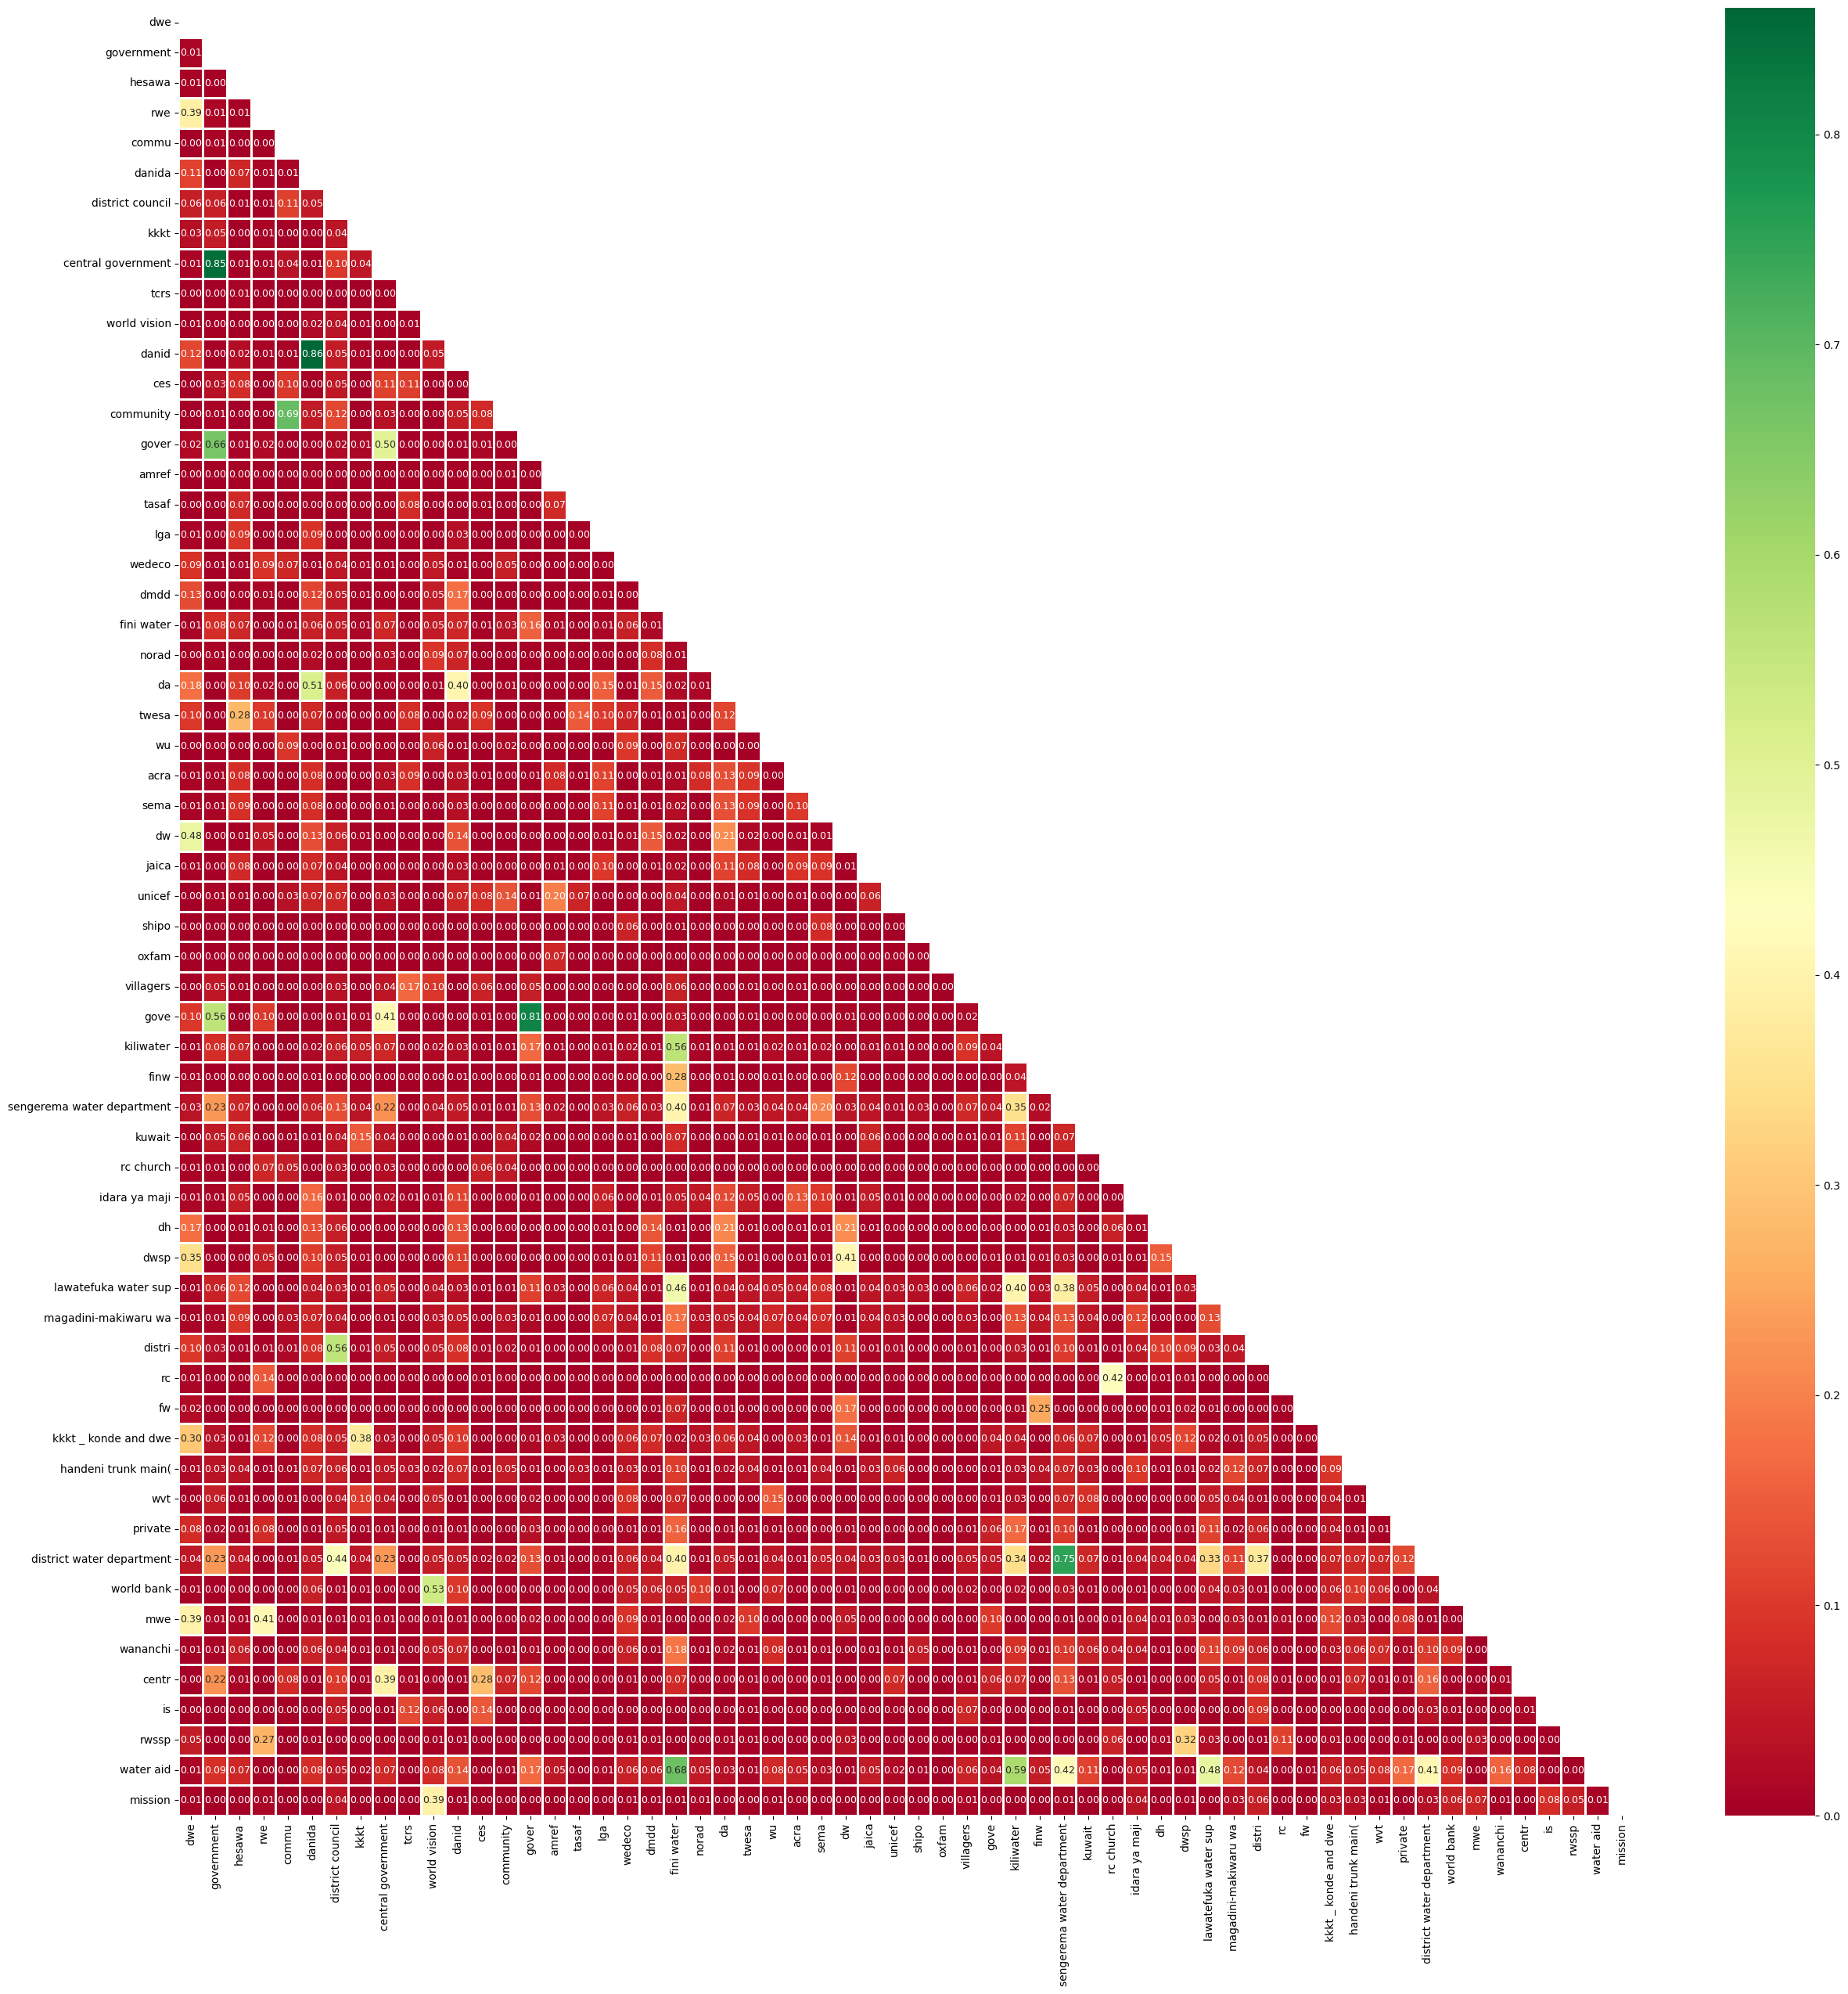

In [171]:
#look at correlatoins in the names of top 60 installers
top_installers = installer.nlargest(60, 'id')['installer'].unique()
encode_and_plot(top_installers)

In [172]:
#there are a few categories in the top 60 most common categories whose naims look a lot alike and are probably typo's. We will merge them together
raw['installer'] = np.where( raw['installer']=='gove', 'gover', raw['installer'] )
raw['installer'] = np.where( raw['installer']=='community', 'commu', raw['installer'] )
raw['installer'] = np.where( raw['installer']=='danid', 'danida', raw['installer'] )

installer = raw.groupby('installer')['id'].count().reset_index()
installer = installer.sort_values('id', ascending = False)
installer.head(10)

,installer,id
431,dwe,21756
567,government,2367
351,danida,2092
295,commu,2044
647,hesawa,1768
1617,rwe,1498
404,district council,1181
876,kkkt,1135
230,central government,933
562,gover,929


In [173]:
#I want to keep the most frequent installers and combine the rarer classes together. I have played around with the optimum number of installers to keep, and I decided on the top 150.

#create list of top 150 installers
top_installers = installer.nlargest(150, 'id')['installer'].unique()

#replace funders that are not in top 10 with 'other'
raw['installer'] = np.where(raw['installer'].isin(top_installers), raw['installer'], 'other')


#### 2.1.6 Funder

In [174]:
#set al entries to lowercase
raw['funder'] = raw['funder'].str.lower()


funder = raw.groupby('funder')['id'].count().reset_index()
funder = funder.sort_values('id', ascending = False)
funder.head(10)


,funder,id
506,government of tanzania,11299
292,danida,3907
572,hesawa,2782
1598,rwssp,1703
2105,world bank,1701
807,kkkt,1623
2107,world vision,1562
1960,unicef,1324
1840,tasaf,1135
326,dhv,1065


In [175]:
#create list of top 150 funders
top_funders = funder.nlargest(150, 'id')['funder'].unique()

#replace funders that are not in top 150 with 'other'
raw['funder'] = np.where(raw['funder'].isin(top_funders), raw['funder'], 'other')


#### 2.1.7 Construction Year

In [176]:
#because of the wide spread of construction years, I don't want to impude by the overall mean
raw['construction_year'].min(),  raw['construction_year'].max() , raw['construction_year'].mean()

(1960.0, 2013.0, 1996.8709430210642)

In [177]:
#We can see that the mean construction year by extraction type group gives much more detailed information
mean_construction = raw.groupby('extraction_type_group')['construction_year'].mean().reset_index()
mean_construction 

,extraction_type_group,construction_year
0,afridev,2002.215589
1,gravity,1996.014441
2,india mark ii,2001.187973
3,india mark iii,2003.975904
4,mono,1992.824017
5,nira/tanira,1999.523877
6,other,1993.272477
7,other handpump,2000.594203
8,other motorpump,2011.400000
9,rope pump,2005.634888


In [178]:
#create df with the mean extraction year by extraction type group
mean_construction = raw.groupby('extraction_type_group')['construction_year'].mean().reset_index()
mean_construction  = mean_construction .rename(columns={"construction_year": "imputed_construction_year"})

#merge this df to the main df and replace missing values
raw = raw.merge(mean_construction, how =  'left', on =  'extraction_type_group')
raw['construction_year_imputed'] = np.where(raw['construction_year'].isna(), raw['imputed_construction_year'], raw['construction_year'] )

#drop redundant columns
raw=raw.drop(['imputed_construction_year', 'construction_year'], axis=1)

#### 2.1.8 GPS height

Tanzania is not located below sealevel, so any negative value for gps height cannot be correct. The normal error is gps altitude is is +- 15 meter and this applies 95% of the time. The other 5% of the time you can have any value. HOwever, here we don't know if the gps height indicates the height of the water level, or the locaton of the well....  If I had known this for sure, I would clamp any negative values to zero. Around 2.5% of the records display a negative altitude. I will impute missing values based on the mean of the regional features 

In [179]:
#create mean on the lowest granularity level (subvillage)
means_altitude_subvillage = raw.groupby(['region', 'lga', 'ward', 'subvillage'])['gps_height'].mean().reset_index()#
means_altitude_subvillage = means_altitude_subvillage.rename(columns={"gps_height": "gps_height_imputed_subvillage"})

#ward level
means_altitude_ward = raw.groupby(['region', 'lga', 'ward',])['gps_height'].mean().reset_index()
means_altitude_ward = means_altitude_ward.rename(columns={"gps_height": "gps_height_imputed_ward"})

#lga level
means_altitude_lga = raw.groupby(['region', 'lga'])['gps_height'].mean().reset_index()
means_altitude_lga = means_altitude_lga .rename(columns={"gps_height": "gps_height_imputed_lga"})

#region level
means_altitude_region = raw.groupby(['region'])['gps_height'].mean().reset_index()
means_altitude_region = means_altitude_region.rename(columns={"gps_height": "gps_height_imputed_region"})

#region basin
means_altitude_basin = raw.groupby(['basin'])['gps_height'].mean().reset_index()
means_altitude_basin = means_altitude_basin.rename(columns={"gps_height": "gps_height_imputed_basin"})

#merge the aggregated dataframes as new columns to the original df
raw= raw.merge(means_altitude_subvillage, how = 'left', on = ['region', 'lga', 'ward', 'subvillage'])
raw = raw.merge(means_altitude_ward, how = 'left', on = ['region', 'lga', 'ward'])
raw = raw.merge(means_altitude_lga, how = 'left', on = ['region', 'lga'])
raw = raw.merge(means_altitude_region, how = 'left', on = ['region'])
raw = raw.merge(means_altitude_basin, how = 'left', on = ['basin'])

#create final imputed longitude column
raw['imputed_gps_height'] = np.where(raw['gps_height'].isna(), raw['gps_height_imputed_subvillage'], raw['gps_height']) #if longitude is missing, impute it by the mean of the subvillage
raw['imputed_gps_height'] = np.where(raw['imputed_gps_height'].isna(), raw['gps_height_imputed_ward'], raw['imputed_gps_height']) #if subvillage mean is missing, impute it by the ward
raw['imputed_gps_height'] = np.where(raw['imputed_gps_height'].isna(), raw['gps_height_imputed_lga'], raw['imputed_gps_height'])
raw['imputed_gps_height'] = np.where(raw['imputed_gps_height'].isna(), raw['gps_height_imputed_region'], raw['imputed_gps_height'])
raw['imputed_gps_height'] = np.where(raw['imputed_gps_height'].isna(), raw['gps_height_imputed_basin'], raw['imputed_gps_height'])

#drop redundant columns
raw= raw.drop(['gps_height_imputed_subvillage','gps_height_imputed_ward' , 'gps_height_imputed_lga' , 'gps_height_imputed_region', 'gps_height', 'gps_height_imputed_basin'], axis=1)


#### 2.1.9 Population

In [180]:
#create mean on the lowest granularity level (subvillage)
means_population_subvillage = raw.groupby(['region', 'lga', 'ward', 'subvillage'])['population'].mean().reset_index()#
means_population_subvillage = means_population_subvillage.rename(columns={"population": "population_imputed_subvillage"})

#ward level
means_population_ward = raw.groupby(['region', 'lga', 'ward',])['population'].mean().reset_index()
means_population_ward = means_population_ward.rename(columns={"population": "population_imputed_ward"})

#lga level
means_population_lga = raw.groupby(['region', 'lga'])['population'].mean().reset_index()
means_population_lga = means_population_lga .rename(columns={"population": "population_imputed_lga"})

#region level
means_population_region = raw.groupby(['region'])['population'].mean().reset_index()
means_population_region = means_population_region.rename(columns={"population": "population_imputed_region"})

#region basin
means_population_basin = raw.groupby(['basin'])['population'].mean().reset_index()
means_population_basin = means_population_basin.rename(columns={"population": "population_imputed_basin"})

#merge the aggregated dataframes as new columns to the original df
raw= raw.merge(means_population_subvillage, how = 'left', on = ['region', 'lga', 'ward', 'subvillage'])
raw = raw.merge(means_population_ward, how = 'left', on = ['region', 'lga', 'ward'])
raw = raw.merge(means_population_lga, how = 'left', on = ['region', 'lga'])
raw = raw.merge(means_population_region, how = 'left', on = ['region'])
raw = raw.merge(means_population_basin, how = 'left', on = ['basin'])

#create final imputed longitude column
raw['imputed_population'] = np.where(raw['population'].isna(), raw['population_imputed_subvillage'], raw['population']) #if longitude is missing, impute it by the mean of the subvillage
raw['imputed_population'] = np.where(raw['imputed_population'].isna(), raw['population_imputed_ward'], raw['imputed_population']) #if subvillage mean is missing, impute it by the ward
raw['imputed_population'] = np.where(raw['imputed_population'].isna(), raw['population_imputed_lga'], raw['imputed_population'])
raw['imputed_population'] = np.where(raw['imputed_population'].isna(), raw['population_imputed_region'], raw['imputed_population'])
raw['imputed_population'] = np.where(raw['imputed_population'].isna(), raw['population_imputed_basin'], raw['imputed_population'])

#drop redundant columns
raw= raw.drop(['population_imputed_subvillage','population_imputed_ward' , 'population_imputed_lga' , 'population_imputed_region', 'population', 'population_imputed_basin'], axis=1)

### 2.2 Data types 

In [181]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74249 entries, 0 to 74248
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id                          74249 non-null  int64         
 1   status_group                59399 non-null  object        
 2   amount_tsh                  22201 non-null  float64       
 3   date_recorded               74249 non-null  datetime64[ns]
 4   funder                      74249 non-null  object        
 5   installer                   74249 non-null  object        
 6   latitude                    74249 non-null  float64       
 7   wpt_name                    74249 non-null  object        
 8   num_private                 951 non-null    float64       
 9   basin                       74249 non-null  object        
 10  subvillage                  73779 non-null  object        
 11  region                      74249 non-null  object    

In [182]:
#replace string to integer
raw['public_meeting'] = raw['public_meeting'].replace({True: 1, False: 0})
raw['imputed_permit'] = raw['imputed_permit'].replace({True: 1, False: 0})


#change to integer
raw[['imputed_gps_height', 'construction_year_imputed', 'imputed_population']] = raw[['imputed_gps_height', 'construction_year_imputed', 'imputed_population']].astype('int')

#change type to categorical
raw[['region_code', 'district_code', 'num_private']] = raw[['region_code', 'district_code', 'num_private']].astype('str')
raw[[ 'num_private']] = raw[[ 'num_private']].astype('str')

#remove decimal
raw['district_code'] = raw['district_code'].str.split(".").str[0]


In [183]:
#save cleaned df
raw= raw.rename(columns={"imputed_permit": "permit", "imputed_scheme__management": "scheme_management",
                    "imputed_gps_height": "gps_height", 'construction_year_imputed': 'construction_year', 
                   'imputed_population': 'population', 'imputed_longitude': 'longitude'}, errors="raise")

raw.to_csv("cleaned_df.csv")

In [184]:
raw.head()

,id,status_group,amount_tsh,date_recorded,funder,installer,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,public_meeting,recorded_by,scheme_name,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,longitude,permit,scheme_management,construction_year,gps_height,population
0,69572,functional,6000.0,2011-03-14,roman,roman,-9.856322,none,nan,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,1,GeoData Consultants Ltd,Roman,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,34.938093,0,VWC,1999,1390,109
1,8776,functional,NaN,2013-03-06,grumeti,grumeti,-2.147466,Zahanati,nan,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,1,GeoData Consultants Ltd,NaN,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,34.698766,1,Other,2010,1399,280
2,34310,functional,25.0,2013-02-25,other,world vision,-3.821329,Kwa Mahundi,nan,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,1,GeoData Consultants Ltd,Nyumba ya mungu pipe scheme,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,37.460664,1,VWC,2009,686,250
3,67743,non functional,NaN,2013-01-28,unicef,unicef,-11.155298,Zahanati Ya Nanyumbu,nan,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,1,GeoData Consultants Ltd,NaN,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,38.486161,1,VWC,1986,263,58
4,19728,functional,NaN,2011-07-13,other,artisan,-1.825359,Shuleni,nan,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,1,GeoData Consultants Ltd,NaN,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,31.130847,1,Other,1996,1328,532


# 3 Feature engineering

In [185]:
final_df = raw.copy()

#### 3.1 Age

In [186]:
#create age feature
final_df['recorded_year'] = pd.DatetimeIndex(final_df ['date_recorded']).year
final_df[ 'age'] = final_df['recorded_year'] - final_df['construction_year']
final_df = final_df.drop('recorded_year',axis=1)

#### 3.2 Season

In [187]:
final_df['month'] = pd.DatetimeIndex(final_df['date_recorded']).month

distribution_checker(final_df, 'month')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
month,,,,,
1,6354,10.7,41.1,46.2,12.7
2,12402,20.9,55.2,37.3,7.5
3,17936,30.2,61.7,33.3,5.0
4,3970,6.7,51.6,37.3,11.0
5,336,0.6,60.1,36.9,3.0
6,346,0.6,78.0,19.4,2.6
7,6928,11.7,50.2,41.9,7.9
8,3364,5.7,51.1,41.4,7.5
9,328,0.6,65.2,31.7,3.0


In [188]:
# season encoder
season_mapper = {1: 'short dry',2:'short dry', 3: 'long rain', 4: 'long rain', 5: 'long rain',6: 'long dry', 
                 7: 'long dry', 8: 'long dry', 9: 'long dry', 10: 'long dry', 11:'short rain', 12:'short rain'}
#.p feature values to scale
final_df['season']=final_df['month'].replace(season_mapper)
final_df=final_df.drop('month', axis=1)


In [189]:
distribution_checker(final_df, 'season')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
season,,,,,
long dry,16432,27.7,51.5,41.6,6.9
long rain,22242,37.4,59.8,34.1,6.1
short dry,18756,31.6,50.4,40.3,9.3
short rain,1969,3.3,52.4,43.0,4.6


#### 3.3 Amount tsh missing

In [190]:
#where amount tsh isn't missing, the percentage of functional pumps is a lot higher
final_df['amount_tsh_missing'] = np.where( final_df['amount_tsh'].isna(), 1, 0)
distribution_checker(final_df, 'amount_tsh_missing')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
amount_tsh_missing,,,,,
0,17761,29.9,70.7,22.2,7.1
1,41638,70.1,47.3,45.4,7.3


#### 3.4 Region district

In [191]:
final_df['region_district'] = final_df['region']+ "-" + final_df['district_code']
region_district = distribution_checker(final_df,  'region_district')
region_district.head()

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
region_district,,,,,
Arusha-1,189,0.3,50.3,33.9,15.9
Arusha-2,1206,2.0,69.6,26.6,3.8
Arusha-3,109,0.2,71.6,20.2,8.3
Arusha-30,326,0.5,96.9,2.8,0.3
Arusha-5,201,0.3,54.2,31.8,13.9



#### 3.5 Coordinates

In [192]:
#two decimal places is 1.1 km accurate. This will provide enough information on the location. Using the full coordinate doesn't provide a lot of general information, but does result in high cardinality
final_df['longitude'] = round(final_df['longitude'], 2)
final_df['latitude'] = round(final_df['latitude'],2)

#### 3.6 Extraction

In [193]:
final_df.groupby([  'extraction_type_class', 'extraction_type_group', 'extraction_type'])['id'].count().reset_index()

,extraction_type_class,extraction_type_group,extraction_type,id
0,gravity,gravity,gravity,33263
1,handpump,afridev,afridev,2207
2,handpump,india mark ii,india mark ii,3029
3,handpump,india mark iii,india mark iii,135
4,handpump,nira/tanira,nira/tanira,10205
5,handpump,other handpump,other - mkulima/shinyanga,2
6,handpump,other handpump,other - play pump,101
7,handpump,other handpump,other - swn 81,284
8,handpump,other handpump,walimi,60
9,handpump,swn 80,swn 80,4588


In [194]:
#i want to keep extraction type class and I will group the extraction type group en type together

#swn 80 and swn 81 become swn
#cemo + climax become other motorpump
# other -mkulima, other -play and walimi become other handpump

swn = ['other - swn 81', 'swn80']
final_df['extraction_type'] =np.where(final_df['extraction_type'].isin(swn), 'swn',  final_df['extraction_type'])

other_handpump = ['other - mkulima/shinyanga', 'other - play pump', 'other - walimi']
final_df['extraction_type']=np.where(final_df['extraction_type'].isin(other_handpump), 'other handpump',  final_df['extraction_type'])

other_motorpump = ['cemo', 'climax']
final_df['extraction_type'] =np.where(final_df['extraction_type'].isin(other_motorpump), 'other motorpump',  final_df['extraction_type'])


In [195]:
distribution_checker(final_df, 'extraction_type_class')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
extraction_type_class,,,,,
gravity,26780,45.1,59.9,30.0,10.1
handpump,16455,27.7,63.1,30.9,6.0
motorpump,2987,5.0,38.0,57.4,4.6
other,6430,10.8,16.0,80.8,3.2
rope pump,451,0.8,65.0,31.3,3.8
submersible,6179,10.4,53.9,42.0,4.1
wind-powered,117,0.2,42.7,51.3,6.0



#### 3.7 autonomy

In [196]:
#autonomous = government, VWC, town council ..... also water authority?, parastatal (=state company)? SWC?
#autonomous = WUA, WUG, board, trust, school
#private = private, company

non = ['VWC', 'Water authority', 'Parastatal', 'SWC']
autonomous = ['WUG', 'WUA', 'Water Board', 'Trust']
private = ['Company', 'Private operator']
other = ['None', 'Other']

final_df['authority_scheme'] = final_df['scheme_management']
final_df.loc[final_df['authority_scheme'].isin(non),'authority_scheme']='non-autonomous'
final_df.loc[final_df['authority_scheme'].isin(autonomous ),'authority_scheme']='autonomous'
final_df.loc[final_df['authority_scheme'].isin(private),'authority_scheme']='private'
final_df.loc[final_df['authority_scheme'].isin(other ),'authority_scheme']='other'

In [197]:
autonomy = distribution_checker(final_df, 'authority_scheme')
autonomy= autonomy.sort_values('nr_pumps', ascending= False)
autonomy

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
authority_scheme,,,,,
non-autonomous,44653,75.2,51.2,41.7,7.1
autonomous,11549,19.4,64.6,26.5,8.9
private,2244,3.8,60.1,37.1,2.8
other,953,1.6,61.5,34.6,3.9


#### 3.8 source type

In [198]:
#source type by source class
final_df.groupby([  'source_class', 'source_type','source' ])['id'].count().reset_index()


,source_class,source_type,source,id
0,groundwater,borehole,hand dtw,1108
1,groundwater,borehole,machine dbh,13822
2,groundwater,shallow well,shallow well,21139
3,groundwater,spring,spring,21216
4,surface,dam,dam,840
5,surface,rainwater harvesting,rainwater harvesting,2863
6,surface,river/lake,lake,950
7,surface,river/lake,river,11964
8,unknown,other,other,261
9,unknown,other,unknown,86


In [199]:
#keep source, but the rare classes will be put together
other = ['other',  'unknown']
final_df['source'] = np.where(final_df['source']=='unknown', 'other', final_df['source'])

#### 3.9 Drop redundant features

In [200]:
#during EDA I already decided what features to keep and which ones to drop
final_df = final_df.drop(['amount_tsh', 'date_recorded', 'wpt_name', 'num_private', 'subvillage', 'region',  'district_code', 'lga', 'ward', 'recorded_by', 'scheme_name', 'extraction_type_group', 'management', 'management_group', 'payment', 'quality_group', 'quantity_group', 'source_class', 'source_type', 'waterpoint_type_group', 'construction_year'], axis=1)
final_df.head()

,id,status_group,funder,installer,latitude,basin,region_code,public_meeting,extraction_type,extraction_type_class,payment_type,water_quality,quantity,source,waterpoint_type,longitude,permit,scheme_management,gps_height,population,age,season,amount_tsh_missing,region_district,authority_scheme
0,69572,functional,roman,roman,-9.86,Lake Nyasa,11,1,gravity,gravity,annually,soft,enough,spring,communal standpipe,34.94,0,VWC,1390,109,12,long rain,0,Iringa-5,non-autonomous
1,8776,functional,grumeti,grumeti,-2.15,Lake Victoria,20,1,gravity,gravity,never pay,soft,insufficient,rainwater harvesting,communal standpipe,34.70,1,Other,1399,280,3,long rain,1,Mara-2,other
2,34310,functional,other,world vision,-3.82,Pangani,21,1,gravity,gravity,per bucket,soft,enough,dam,communal standpipe multiple,37.46,1,VWC,686,250,4,short dry,0,Manyara-4,non-autonomous
3,67743,non functional,unicef,unicef,-11.16,Ruvuma / Southern Coast,90,1,submersible,submersible,never pay,soft,dry,machine dbh,communal standpipe multiple,38.49,1,VWC,263,58,27,short dry,1,Mtwara-63,non-autonomous
4,19728,functional,other,artisan,-1.83,Lake Victoria,18,1,gravity,gravity,never pay,soft,seasonal,rainwater harvesting,communal standpipe,31.13,1,Other,1328,532,15,long dry,1,Kagera-1,other


#### 3.10 Encoding

In [201]:
#define train and test 
train_set = final_df [final_df ["id"].isin(train_values["id"])]
test_set =  final_df  [final_df  ["id"].isin(test_values["id"])]

In [202]:
X = train_set.drop(['id', 'status_group'], axis=1)
y = train_set['status_group']

In [203]:
print(type(X))

<class 'pandas.core.frame.DataFrame'>


In [204]:
categorical_cols = [cname for cname in X .columns if
                   X [cname].dtype == "object"]

categorical_cols

['funder',
 'installer',
 'basin',
 'region_code',
 'extraction_type',
 'extraction_type_class',
 'payment_type',
 'water_quality',
 'quantity',
 'source',
 'waterpoint_type',
 'scheme_management',
 'season',
 'region_district',
 'authority_scheme']

In [205]:
distribution_checker(final_df, 'waterpoint_type')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
waterpoint_type,,,,,
cattle trough,116,0.2,72.4,25.9,1.7
communal standpipe,28522,48.0,62.1,29.9,7.9
communal standpipe multiple,6103,10.3,36.6,52.8,10.6
dam,7,0.0,85.7,14.3,0.0
hand pump,17487,29.4,61.8,32.3,5.9
improved spring,784,1.3,71.8,17.3,10.8
other,6380,10.7,13.2,82.2,4.6


In [206]:
# Encode Categorical Columns 
for col in categorical_cols:
  le = LabelEncoder()
  train_set[col] = le.fit_transform(train_set[col])
  test_set[col] = le.transform(test_set[col])


/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_5399/3744793663.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[col] = le.fit_transform(train_set[col])
/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_5399/3744793663.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[col] = le.transform(test_set[col])
/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_5399/3744793663.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [207]:
#merge the encoded train and test sets together
final_df = train_set.append(test_set)
final_df.head()

/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_5399/47688359.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = train_set.append(test_set)


,id,status_group,funder,installer,latitude,basin,region_code,public_meeting,extraction_type,extraction_type_class,payment_type,water_quality,quantity,source,waterpoint_type,longitude,permit,scheme_management,gps_height,population,age,season,amount_tsh_missing,region_district,authority_scheme
0,69572,functional,107,108,-9.86,1,2,1,1,0,0,6,1,8,1,34.94,0,7,1390,109,12,1,0,20,1
1,8776,functional,45,47,-2.15,4,12,1,1,0,2,6,2,5,1,34.70,1,2,1399,280,3,1,1,55,2
2,34310,functional,95,148,-3.82,5,13,1,1,0,5,6,1,0,2,37.46,1,7,686,250,4,2,0,52,1
3,67743,non functional,136,129,-11.16,7,25,1,11,5,2,6,0,3,2,38.49,1,7,263,58,27,2,1,76,1
4,19728,functional,95,7,-1.83,4,9,1,1,0,2,6,3,5,1,31.13,1,2,1328,532,15,0,1,22,2


In [208]:
final_df.to_csv("final_df.csv")

**Future work**
* Calculate the mean/median/mode only in the train set and use this to impute missing data in both the train and the test set in order to avoid-overfitting